In [1]:
from data.loader import DataLoader
from data.preprocessing import normalize_images, add_channel_dimension, one_hot_encode, filter_and_reindex_with_mapping
from eda.visualizations import plot_pixel_distribution, display_one_random_image_per_class, plot_class_distribution, plot_average_images, plot_dimensionality_reduction
from models.cnn import build_cnn_model, train_cnn_model
from models.evaluation import  plot_training_history, evaluate_model, test_single_sample, evaluate_single_image
from utils import set_japanese_font
import json

from sklearn.model_selection import train_test_split

In [2]:
# CONSTS
num_records = 46 * 208 * 2
epochs = 50

katakana_chars_modern = [
    "ア", "イ", "ウ", "エ", "オ",  # A-row
    "カ", "キ", "ク", "ケ", "コ",  # K-row
    "サ", "シ", "ス", "セ", "ソ",  # S-row
    "タ", "チ", "ツ", "テ", "ト",  # T-row
    "ナ", "ニ", "ヌ", "ネ", "ノ",  # N-row
    "ハ", "ヒ", "フ", "ヘ", "ホ",  # H-row
    "マ", "ミ", "ム", "メ", "モ",  # M-row
    "ヤ",       "ユ",      "ヨ",   # Y-row
    "ラ", "リ", "ル", "レ", "ロ",  # R-row
    "ワ",                "ヲ",     # W-row
    "ン"                         # N
]

katakana_chars = [
    # A-row
    "ア", "イ", "ウ", "エ", "オ",
    # K-row
    "カ", "キ", "ク", "ケ", "コ",
    # S-row
    "サ", "シ", "ス", "セ", "ソ",
    # T-row
    "タ", "チ", "ツ", "テ", "ト",
    # N-row
    "ナ", "ニ", "ヌ", "ネ", "ノ",
    # H-row
    "ハ", "ヒ", "フ", "ヘ", "ホ",
    # M-row
    "マ", "ミ", "ム", "メ", "モ",
    # Y-row
    "ヤ", "イェ", "ユ", "イォ", "ヨ", # obsolete (イェ, イォ)
    # R-row
    "ラ", "リ", "ル", "レ", "ロ",
    # W-row (now complete!) # obsolete (ヰ, ヱ, ヮ)
    "ワ", "ヰ", "ヱ", "ヲ", "ヮ",
    # N
    "ン",
    # Historical/Obsolete
    # "ヸ", "ヹ", "ヺ", "ヿ"
]


invalid_label_indices = [36, 38, 46, 47, 48]

for label in invalid_label_indices:
    print(katakana_chars[label])


イェ
イォ
ヰ
ヱ
ヲ


In [3]:
class Main:
    def __init__(self, file_path = 'ETL5C'):
        self.file_path = file_path
        self.data = None
        self.labels = None
        self.mapped = None
        self.model = None 
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.history = None

    def load_data(self):
        loader = DataLoader(self.file_path)
        images, labels = loader.load(num_records=num_records)
        self.data = images
        self.labels = labels

    def preprocess(self):
        images = normalize_images(self.data)
        images = add_channel_dimension(images)
        self.data, int_labels, self.mapped, self.mapping = filter_and_reindex_with_mapping(
            images, invalid_label_indices)
        self.labels = one_hot_encode(int_labels, num_classes=len(self.mapping))


    # def create_class_names(self):
    #     reverse_mapping = {new_idx: orig_idx for orig_idx, new_idx in self.mapping.items()}
    #     self.class_names = []
    #     for i in range(len(self.mapping)):
    #         orig_idx = reverse_mapping[i]
    #         if orig_idx < len(katakana_chars_modern):
    #             self.class_names.append(katakana_chars_modern[orig_idx])
    #         else:
    #             self.class_names.append(f"Unknown-{orig_idx}")
    #     print(f"Created class names list with {len(self.class_names)} classes")

    #     # Save the class names to a JSON file
    #     with open('class_names.json', 'w') as f:
    #         json.dump(self.class_names, f)
    #     print("Class names saved to class_names.json")

    def eda(self):
        display_one_random_image_per_class(self.mapped, katakana_chars_modern)
        plot_average_images(self.labels, self.data, katakana_chars_modern)
        plot_pixel_distribution(self.data)
        plot_class_distribution(self.labels)
        plot_dimensionality_reduction(self.data, self.labels)


    def build_model(self):
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            self.data, self.labels, test_size=0.2, random_state=42)
        self.model = build_cnn_model(input_shape=self.X_train.shape[1:], num_classes=self.y_train.shape[1], learning_rate=0.001)
        self.model.summary()

        self.history = train_cnn_model(self.model, self.X_train, self.y_train, self.X_test, self.y_test, epochs=epochs, batch_size=32)

        self.class_names = katakana_chars_modern
        print(self.class_names)


    def evaluate_model(self):
        plot_training_history(self.history)
        self.class_names = katakana_chars_modern
        evaluate_model(self.model, self.X_test, self.y_test, class_names=self.class_names)
    

In [4]:
set_japanese_font()
pipeline = Main()
pipeline.load_data()
pipeline.preprocess()

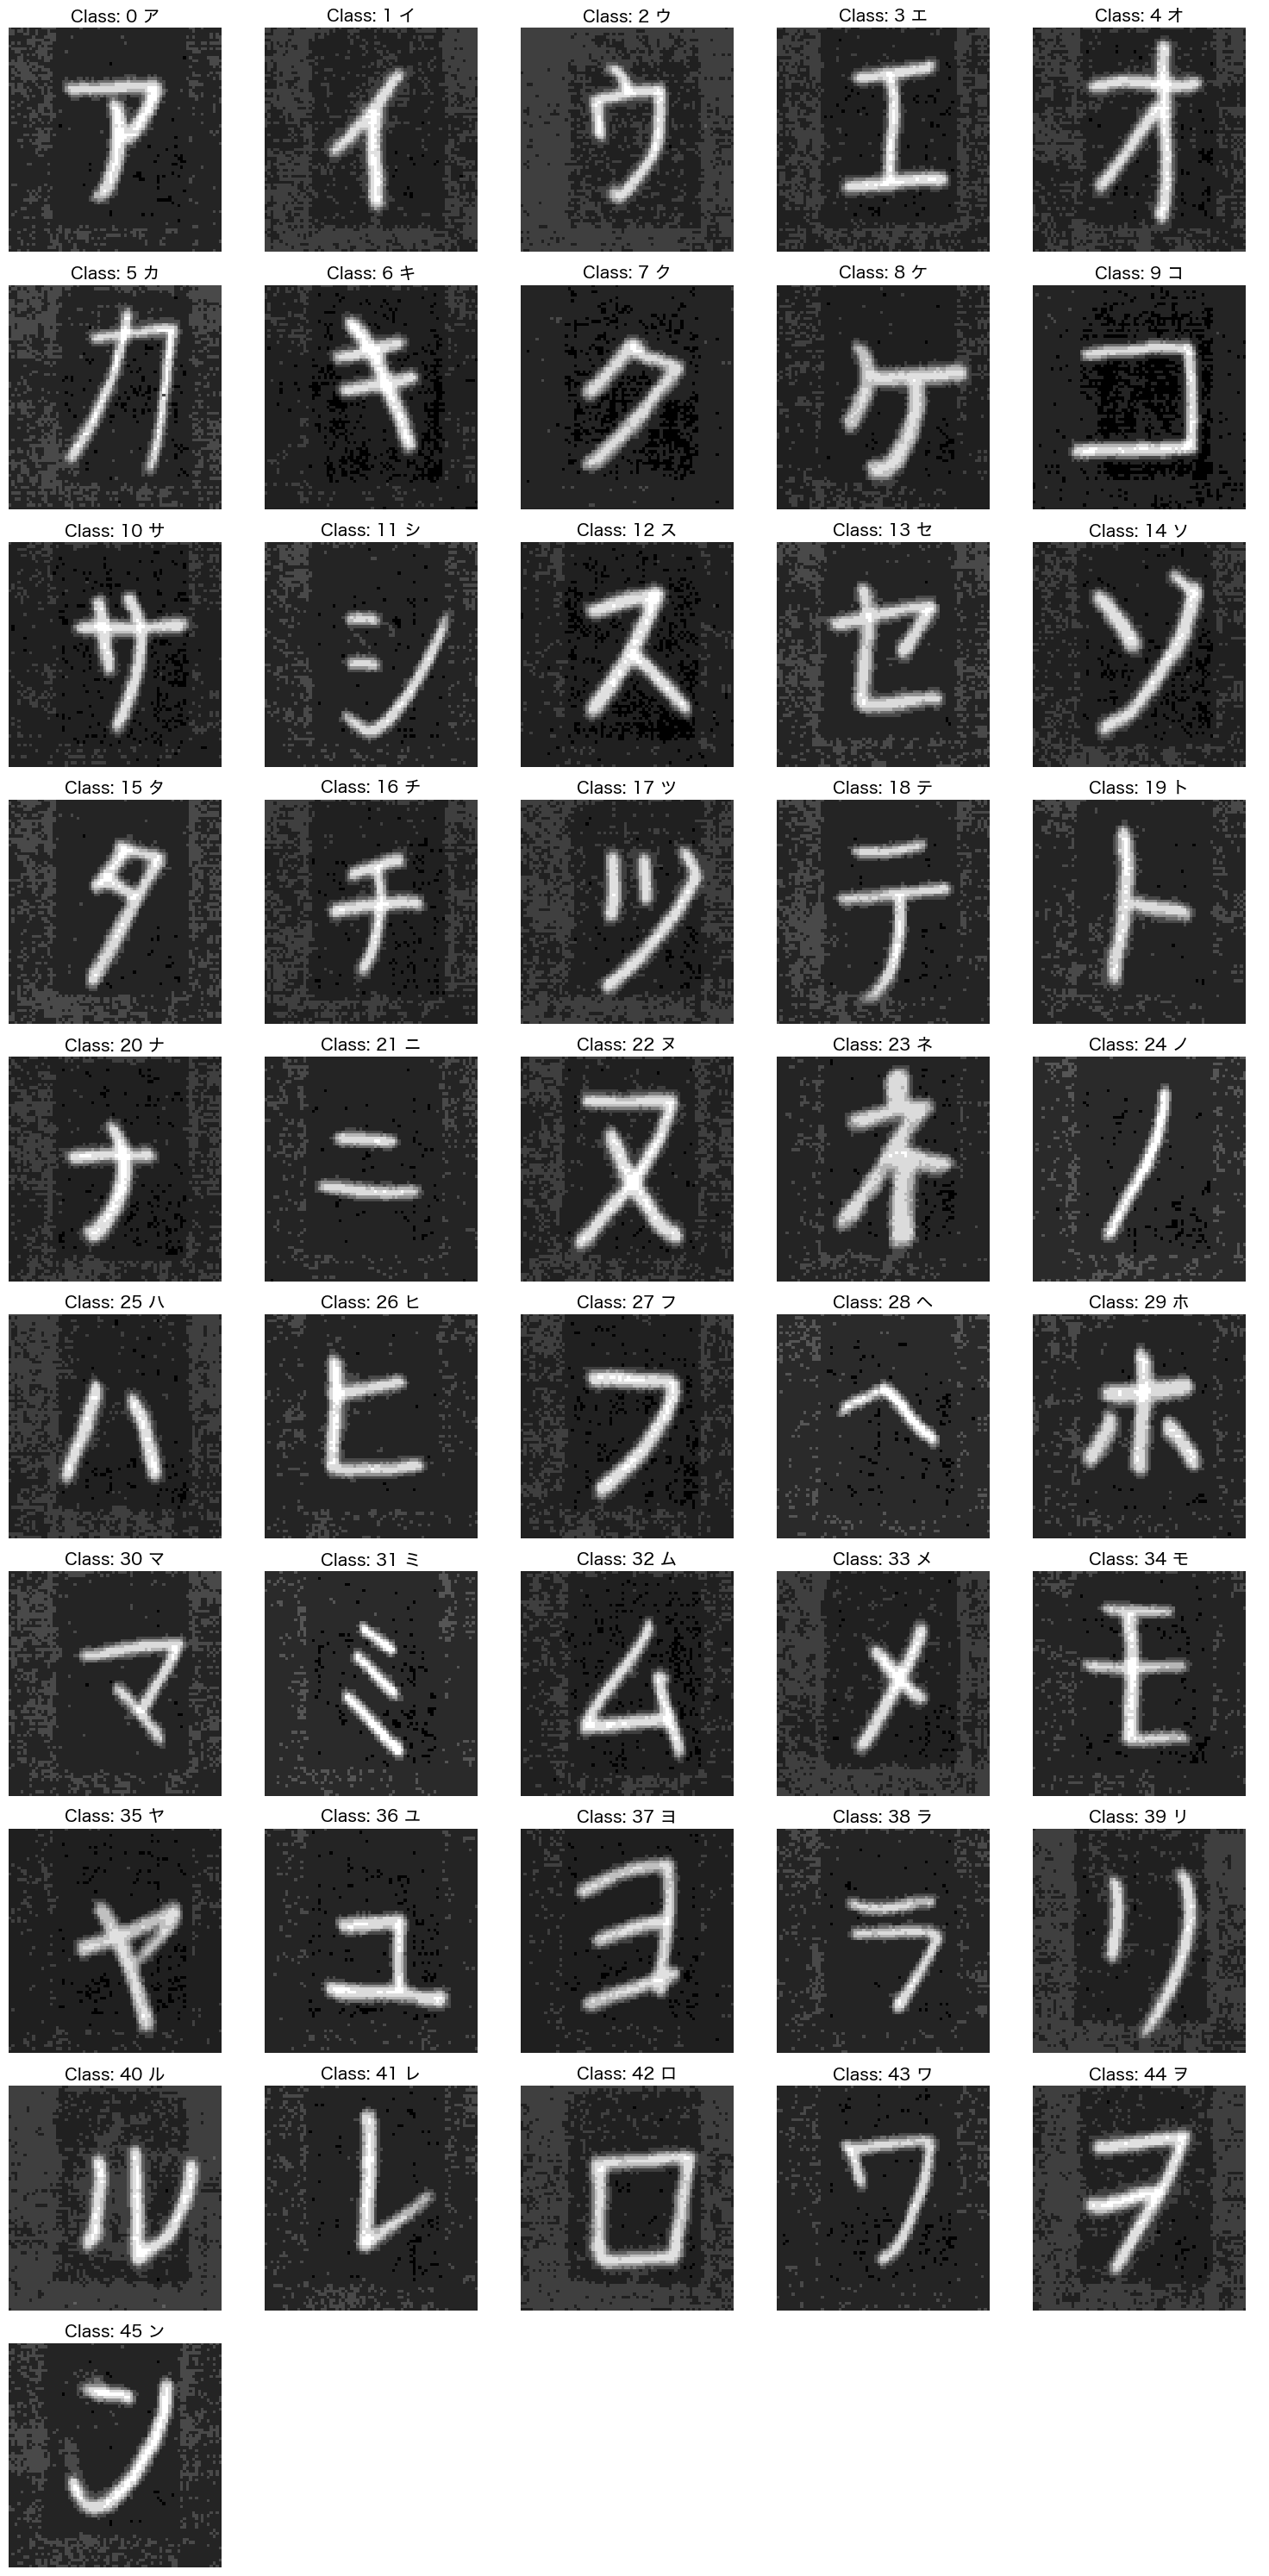

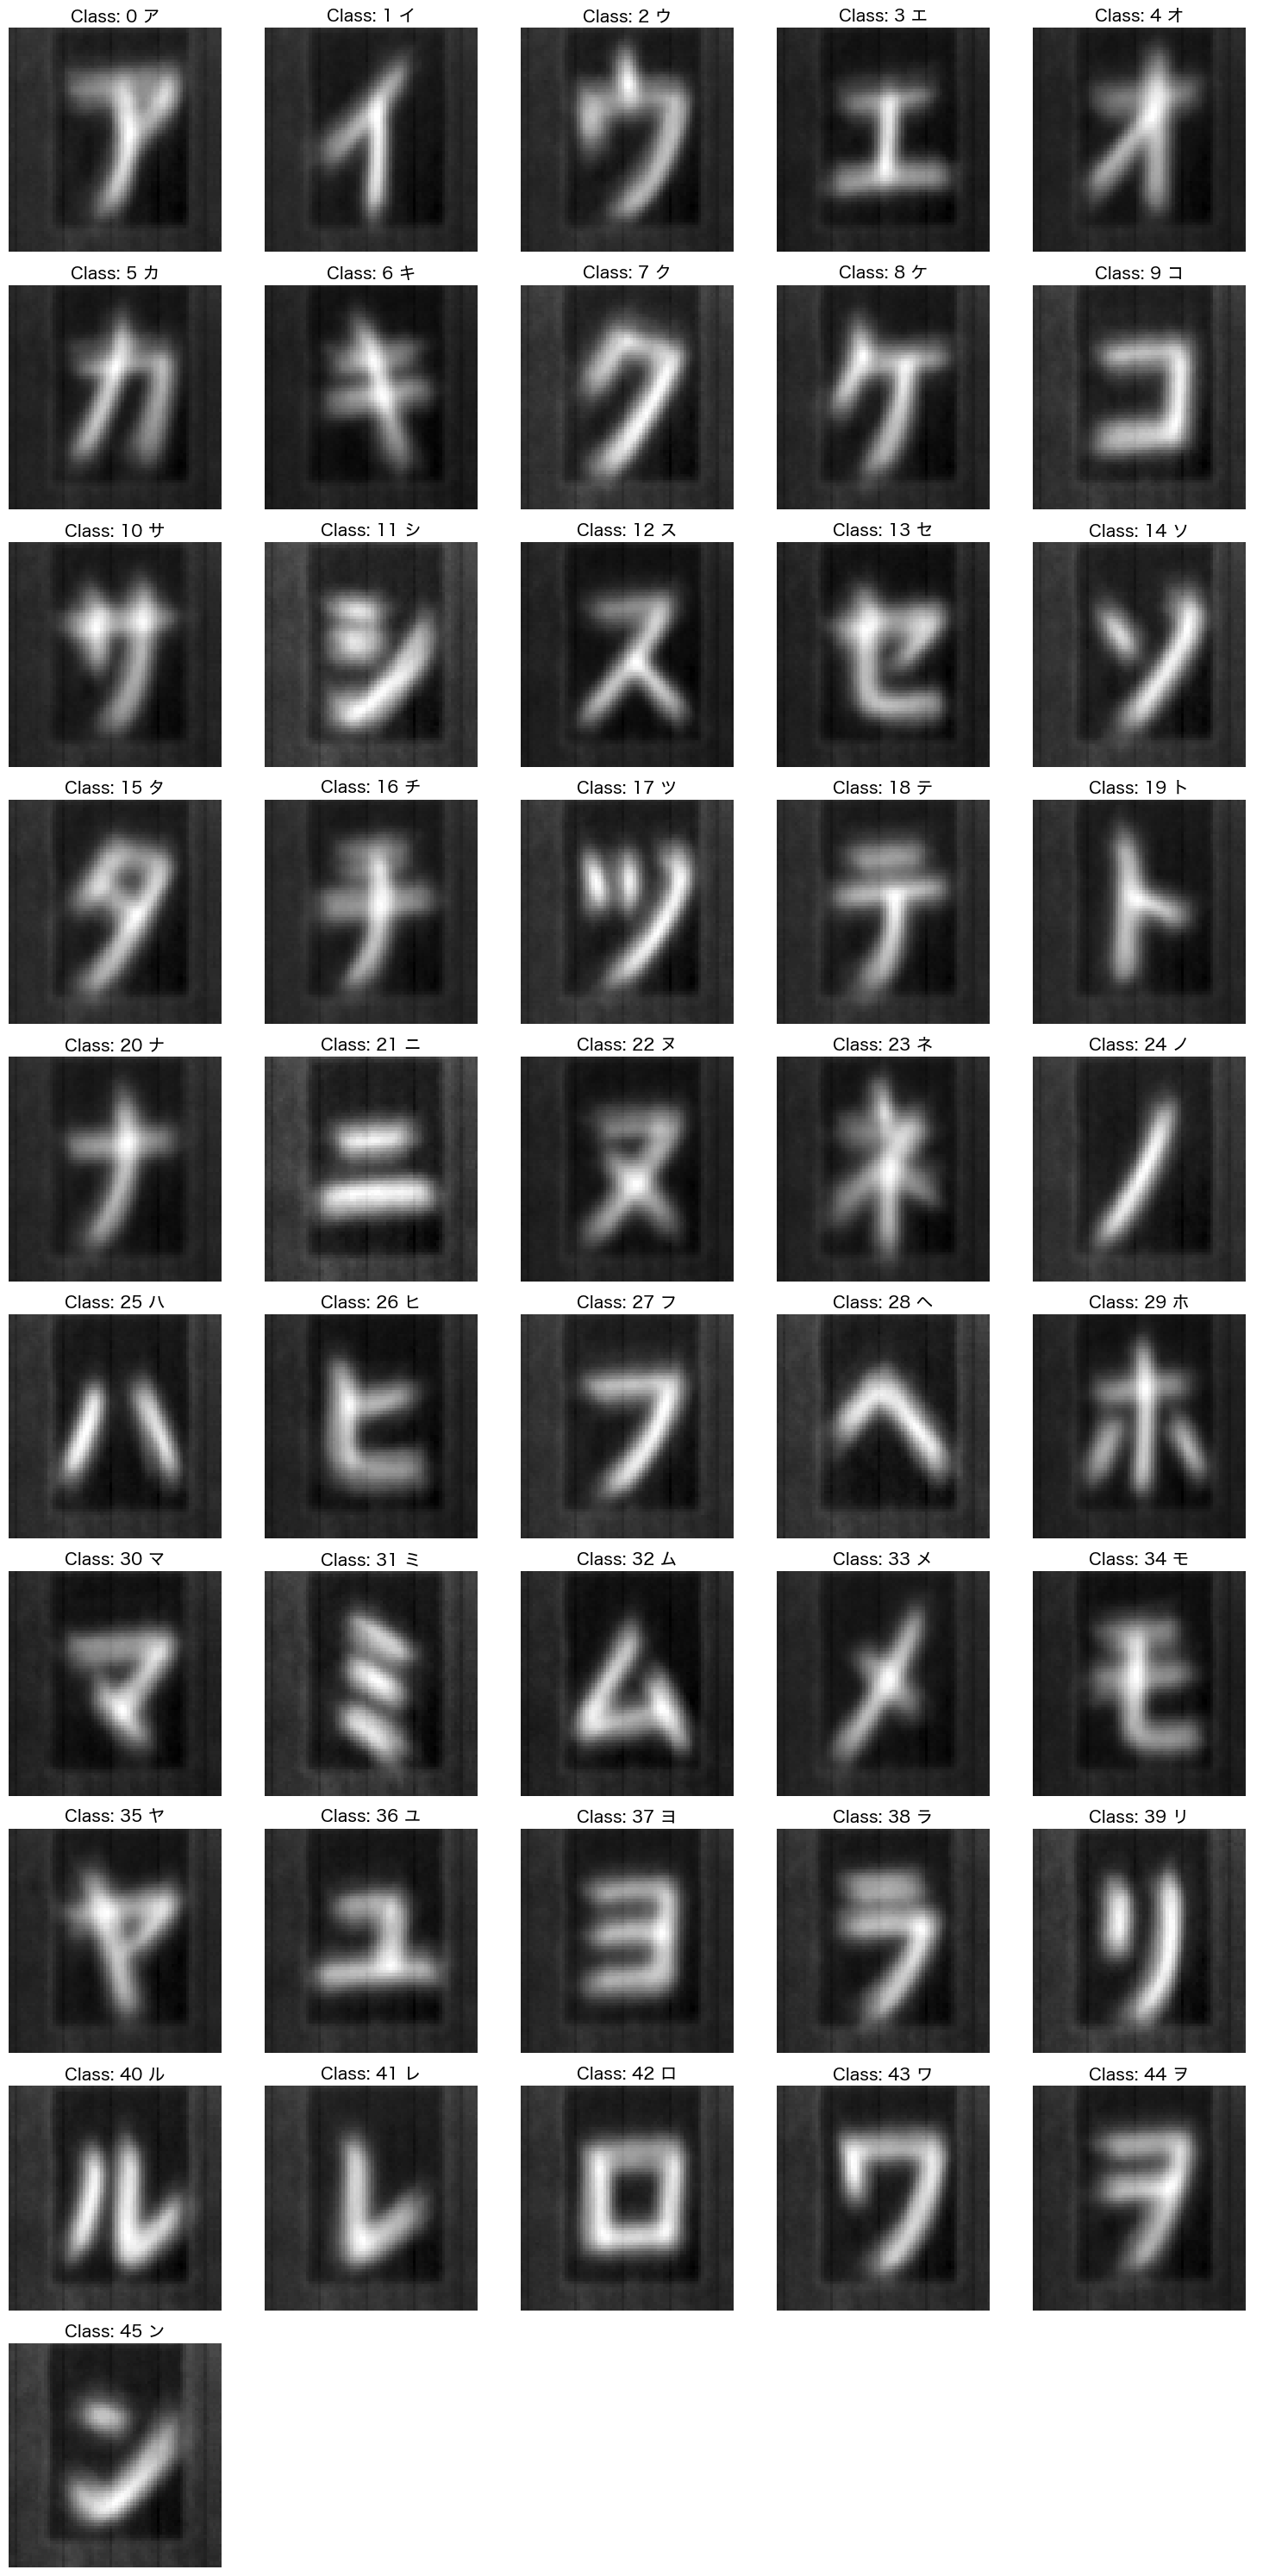

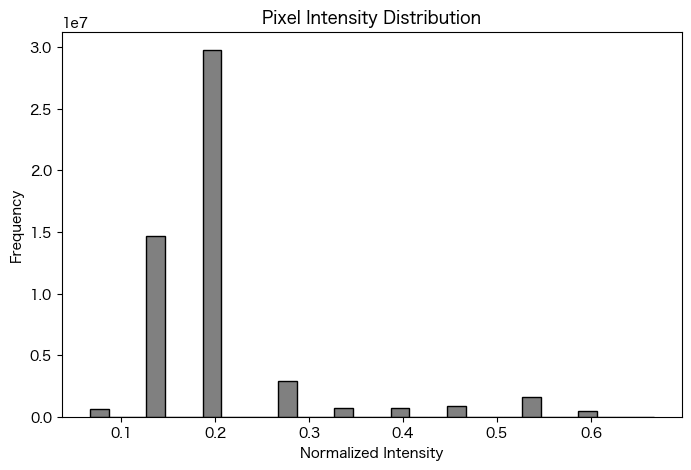

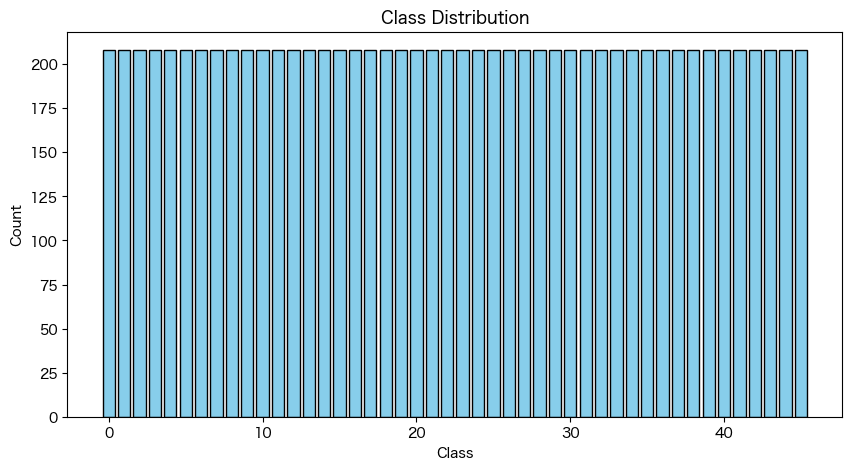

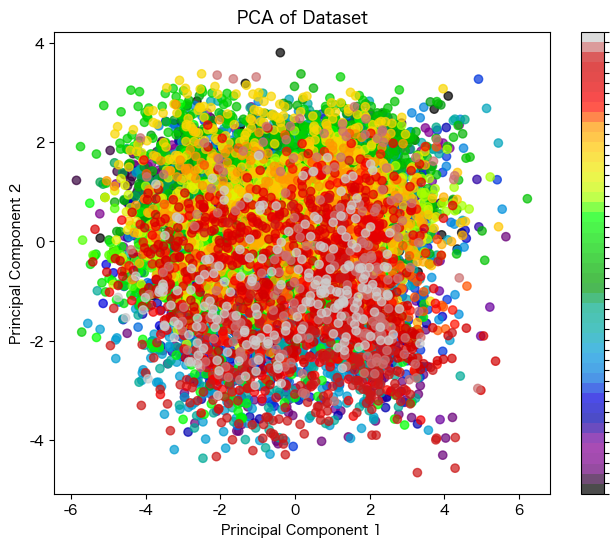

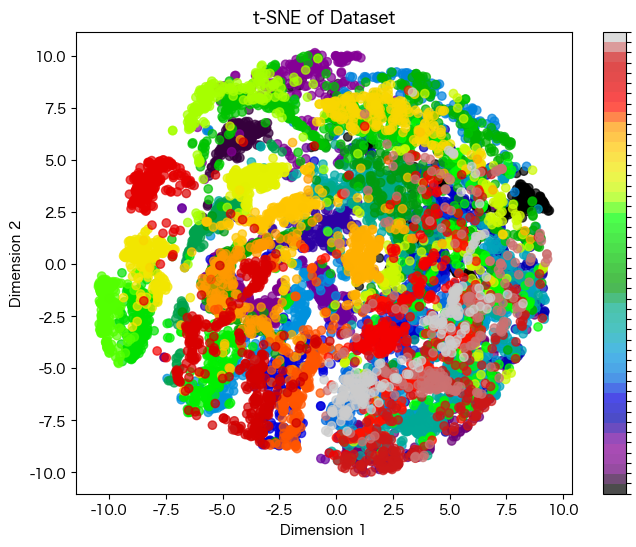

In [5]:
pipeline.eda()

/Users/sid/Desktop/ETL5/venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 76, 72, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 76, 72, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 76, 72, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 76, 72, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 38, 36, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 38, 36, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 38, 36, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 38, 36, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 38, 36, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 38, 36, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 19, 18, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 19, 18, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 19, 18, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 19, 18, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 19, 18, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 19, 18, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 10368)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     2,654,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 2,955,534 (11.27 MB)

 Trainable params: 2,954,126 (11.27 MB)

 Non-trainable params: 1,408 (5.50 KB)

Epoch 1/50

Epoch 1: val_loss improved from inf to 7.03464, saving model to best_model.h5


240/240 - 36s - 148ms/step - accuracy: 0.6851 - loss: 1.2758 - val_accuracy: 0.0219 - val_loss: 7.0346 - learning_rate: 1.0000e-03
Epoch 2/50

Epoch 2: val_loss improved from 7.03464 to 1.97097, saving model to best_model.h5


240/240 - 36s - 150ms/step - accuracy: 0.9403 - loss: 0.2707 - val_accuracy: 0.3966 - val_loss: 1.9710 - learning_rate: 1.0000e-03
Epoch 3/50

Epoch 3: val_loss improved from 1.97097 to 0.09492, saving model to best_model.h5


240/240 - 38s - 157ms/step - accuracy: 0.9730 - loss: 0.1331 - val_accuracy: 0.9781 - val_loss: 0.0949 - learning_rate: 1.0000e-03
Epoch 4/50

Epoch 4: val_loss improved from 0.09492 to 0.03872, saving model to best_model.h5


240/240 - 38s - 159ms/step - accuracy: 0.9838 - loss: 0.0872 - val_accuracy: 0.9916 - val_loss: 0.0387 - learning_rate: 1.0000e-03
Epoch 5/50

Epoch 5: val_loss did not improve from 0.03872
240/240 - 38s - 158ms/step - accuracy: 0.9889 - loss: 0.0589 - val_accuracy: 0.9859 - val_loss: 0.0524 - learning_rate: 1.0000e-03
Epoch 6/50

Epoch 6: val_loss improved from 0.03872 to 0.03724, saving model to best_model.h5


240/240 - 38s - 159ms/step - accuracy: 0.9922 - loss: 0.0458 - val_accuracy: 0.9922 - val_loss: 0.0372 - learning_rate: 1.0000e-03
Epoch 7/50

Epoch 7: val_loss improved from 0.03724 to 0.03454, saving model to best_model.h5


240/240 - 38s - 160ms/step - accuracy: 0.9903 - loss: 0.0422 - val_accuracy: 0.9927 - val_loss: 0.0345 - learning_rate: 1.0000e-03
Epoch 8/50

Epoch 8: val_loss improved from 0.03454 to 0.02733, saving model to best_model.h5


240/240 - 37s - 154ms/step - accuracy: 0.9941 - loss: 0.0334 - val_accuracy: 0.9943 - val_loss: 0.0273 - learning_rate: 1.0000e-03
Epoch 9/50

Epoch 9: val_loss did not improve from 0.02733
240/240 - 35s - 147ms/step - accuracy: 0.9957 - loss: 0.0258 - val_accuracy: 0.9937 - val_loss: 0.0301 - learning_rate: 1.0000e-03
Epoch 10/50

Epoch 10: val_loss did not improve from 0.02733
240/240 - 36s - 150ms/step - accuracy: 0.9910 - loss: 0.0393 - val_accuracy: 0.9943 - val_loss: 0.0278 - learning_rate: 1.0000e-03
Epoch 11/50

Epoch 11: val_loss did not improve from 0.02733
240/240 - 37s - 155ms/step - accuracy: 0.9926 - loss: 0.0325 - val_accuracy: 0.9875 - val_loss: 0.0493 - learning_rate: 1.0000e-03
Epoch 12/50

Epoch 12: val_loss improved from 0.02733 to 0.02668, saving model to best_model.h5


240/240 - 1704s - 7s/step - accuracy: 0.9943 - loss: 0.0253 - val_accuracy: 0.9953 - val_loss: 0.0267 - learning_rate: 1.0000e-03
Epoch 13/50

Epoch 13: val_loss did not improve from 0.02668
240/240 - 848s - 4s/step - accuracy: 0.9970 - loss: 0.0167 - val_accuracy: 0.9943 - val_loss: 0.0288 - learning_rate: 1.0000e-03
Epoch 14/50

Epoch 14: val_loss improved from 0.02668 to 0.01702, saving model to best_model.h5


240/240 - 36s - 149ms/step - accuracy: 0.9953 - loss: 0.0186 - val_accuracy: 0.9974 - val_loss: 0.0170 - learning_rate: 1.0000e-03
Epoch 15/50

Epoch 15: val_loss did not improve from 0.01702
240/240 - 35s - 144ms/step - accuracy: 0.9976 - loss: 0.0106 - val_accuracy: 0.9932 - val_loss: 0.0297 - learning_rate: 1.0000e-03
Epoch 16/50

Epoch 16: val_loss did not improve from 0.01702
240/240 - 35s - 145ms/step - accuracy: 0.9931 - loss: 0.0242 - val_accuracy: 0.9937 - val_loss: 0.0317 - learning_rate: 1.0000e-03
Epoch 17/50

Epoch 17: val_loss did not improve from 0.01702
240/240 - 35s - 147ms/step - accuracy: 0.9892 - loss: 0.0384 - val_accuracy: 0.9833 - val_loss: 0.0522 - learning_rate: 1.0000e-03
Epoch 18/50

Epoch 18: val_loss did not improve from 0.01702
240/240 - 36s - 150ms/step - accuracy: 0.9943 - loss: 0.0237 - val_accuracy: 0.9922 - val_loss: 0.0348 - learning_rate: 1.0000e-03
Epoch 19/50

Epoch 19: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 19: 

240/240 - 37s - 153ms/step - accuracy: 0.9995 - loss: 0.0036 - val_accuracy: 0.9979 - val_loss: 0.0160 - learning_rate: 5.0000e-04
Epoch 24/50

Epoch 24: val_loss did not improve from 0.01603
240/240 - 36s - 151ms/step - accuracy: 0.9996 - loss: 0.0026 - val_accuracy: 0.9974 - val_loss: 0.0173 - learning_rate: 5.0000e-04
Epoch 25/50

Epoch 25: val_loss did not improve from 0.01603
240/240 - 36s - 152ms/step - accuracy: 0.9991 - loss: 0.0045 - val_accuracy: 0.9979 - val_loss: 0.0195 - learning_rate: 5.0000e-04
Epoch 26/50

Epoch 26: val_loss did not improve from 0.01603
240/240 - 36s - 150ms/step - accuracy: 0.9988 - loss: 0.0045 - val_accuracy: 0.9979 - val_loss: 0.0207 - learning_rate: 5.0000e-04
Epoch 27/50

Epoch 27: val_loss did not improve from 0.01603
240/240 - 37s - 152ms/step - accuracy: 0.9999 - loss: 0.0022 - val_accuracy: 0.9990 - val_loss: 0.0186 - learning_rate: 5.0000e-04
Epoch 28/50

Epoch 28: val_loss improved from 0.01603 to 0.01416, saving model to best_model.h5


240/240 - 36s - 150ms/step - accuracy: 0.9996 - loss: 0.0019 - val_accuracy: 0.9990 - val_loss: 0.0142 - learning_rate: 5.0000e-04
Epoch 29/50

Epoch 29: val_loss did not improve from 0.01416
240/240 - 36s - 149ms/step - accuracy: 0.9991 - loss: 0.0030 - val_accuracy: 0.8662 - val_loss: 4.8354 - learning_rate: 5.0000e-04
Epoch 30/50

Epoch 30: val_loss did not improve from 0.01416
240/240 - 36s - 150ms/step - accuracy: 0.9979 - loss: 0.0064 - val_accuracy: 0.9979 - val_loss: 0.0170 - learning_rate: 5.0000e-04
Epoch 31/50

Epoch 31: val_loss did not improve from 0.01416
240/240 - 37s - 152ms/step - accuracy: 0.9984 - loss: 0.0061 - val_accuracy: 0.9974 - val_loss: 0.0204 - learning_rate: 5.0000e-04
Epoch 32/50

Epoch 32: val_loss did not improve from 0.01416
240/240 - 2360s - 10s/step - accuracy: 0.9987 - loss: 0.0067 - val_accuracy: 0.9969 - val_loss: 0.0199 - learning_rate: 5.0000e-04
Epoch 33/50

Epoch 33: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 33: 

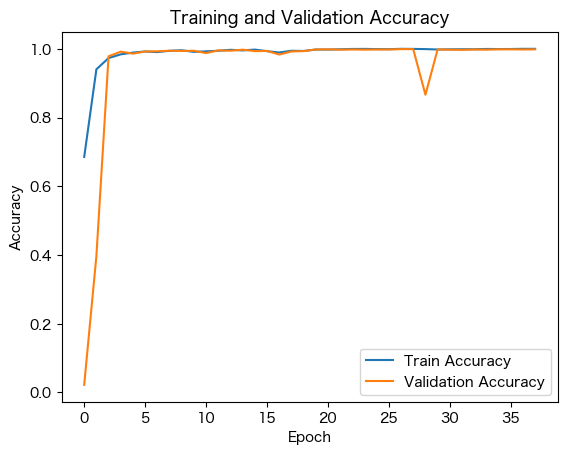

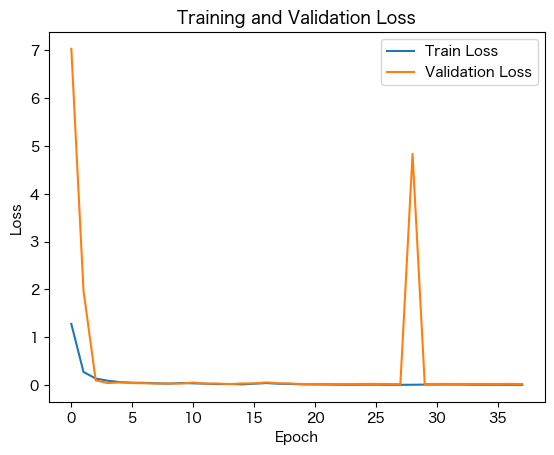

60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step
              precision    recall  f1-score   support

           ア     1.0000    1.0000    1.0000        43
           イ     1.0000    0.9773    0.9885        44
           ウ     1.0000    1.0000    1.0000        45
           エ     1.0000    1.0000    1.0000        41
           オ     1.0000    1.0000    1.0000        38
           カ     1.0000    1.0000    1.0000        43
           キ     1.0000    1.0000    1.0000        45
           ク     1.0000    1.0000    1.0000        45
           ケ     1.0000    1.0000    1.0000        45
           コ     1.0000    1.0000    1.0000        32
           サ     1.0000    1.0000    1.0000        46
           シ     1.0000    1.0000    1.0000        42
           ス     1.0000    1.0000    1.0000        41
           セ     1.0000    1.0000    1.0000        45
           ソ     1.0000    1.0000    1.0000        52
           タ     1.0000    1.0000    1.0000        41
           チ     1.0000    1.0000    1.00

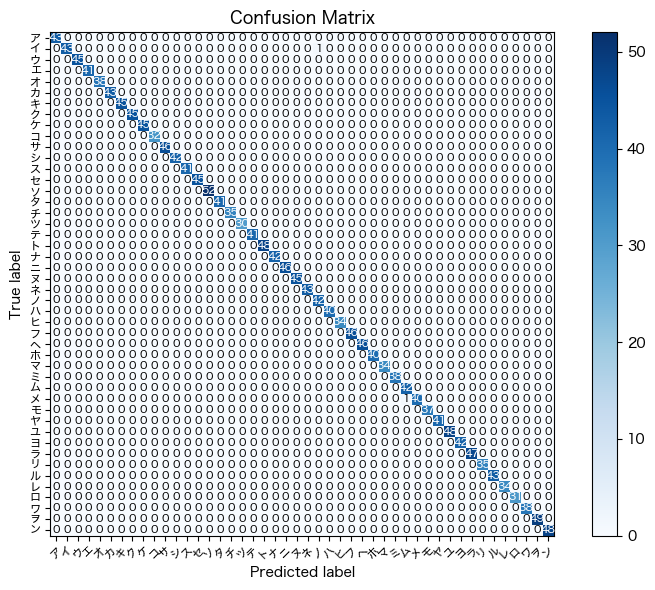

In [6]:
pipeline.build_model()
pipeline.evaluate_model()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


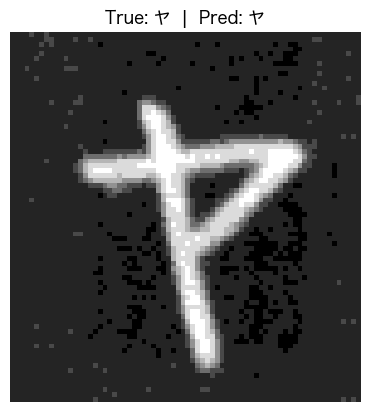

In [7]:
test_single_sample(pipeline.model, pipeline.X_test, pipeline.y_test, pipeline.class_names, pipeline.mapped)

Processing: ./my_imgs/test1.jpg
Inversion detected: inverting image.
Low contrast detected (std = 0.032): enhancing contrast.
DEBUG: Original image - mean: 0.204, std: 0.048
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


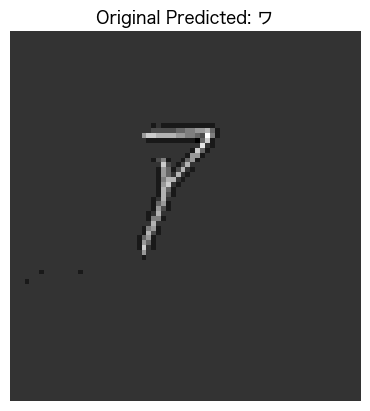

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


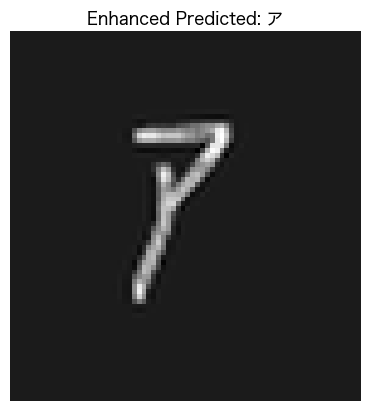

Processing: ./my_imgs/test2.jpg
Inversion detected: inverting image.
Low contrast detected (std = 0.033): enhancing contrast.
DEBUG: Original image - mean: 0.129, std: 0.071
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


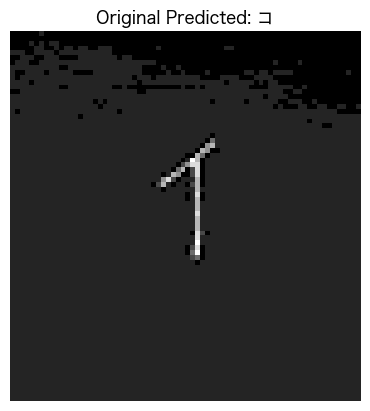

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


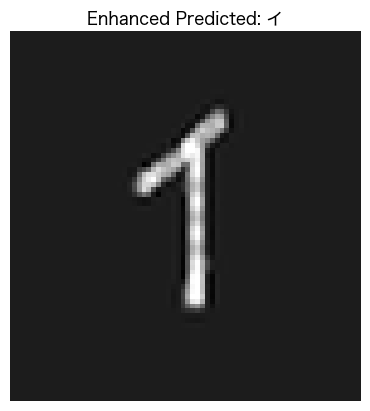

Processing: ./my_imgs/test3.jpg
Inversion detected: inverting image.
Low contrast detected (std = 0.045): enhancing contrast.
DEBUG: Original image - mean: 0.210, std: 0.076
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


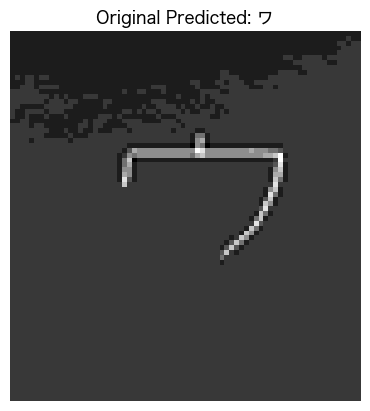

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


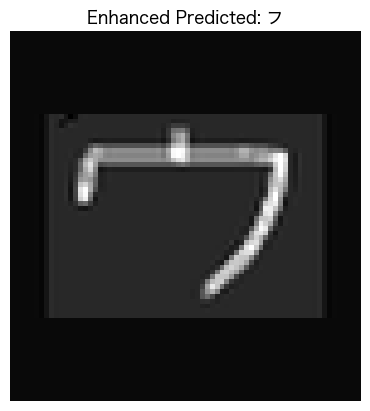

Processing: ./my_imgs/test4.jpg
Inversion detected: inverting image.
Low contrast detected (std = 0.045): enhancing contrast.
DEBUG: Original image - mean: 0.172, std: 0.062
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


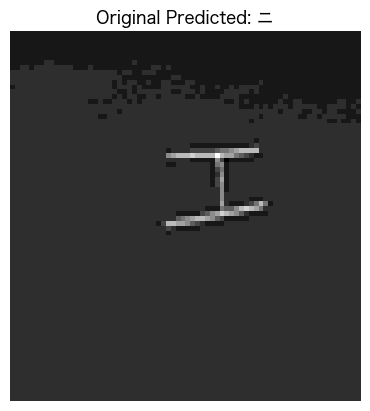

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


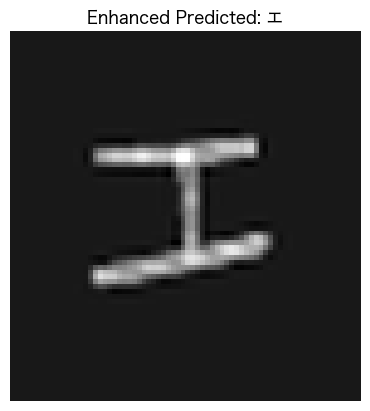

Processing: ./my_imgs/test5.jpg
Inversion detected: inverting image.
Low contrast detected (std = 0.046): enhancing contrast.
DEBUG: Original image - mean: 0.209, std: 0.077
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


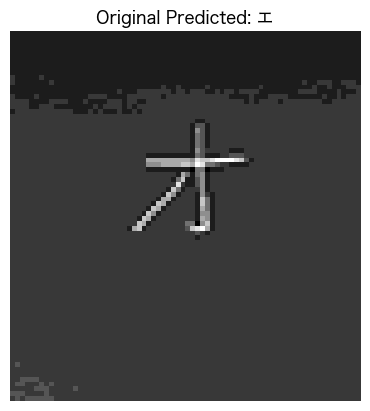

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


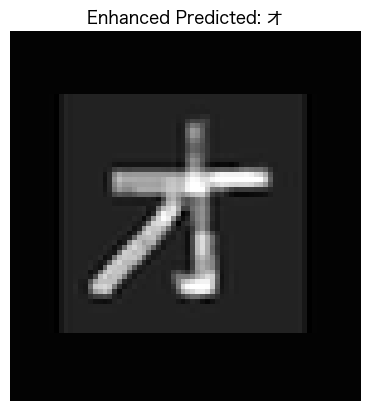

Processing: ./my_imgs/test6.jpg
Inversion detected: inverting image.
Low contrast detected (std = 0.043): enhancing contrast.
DEBUG: Original image - mean: 0.118, std: 0.080
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


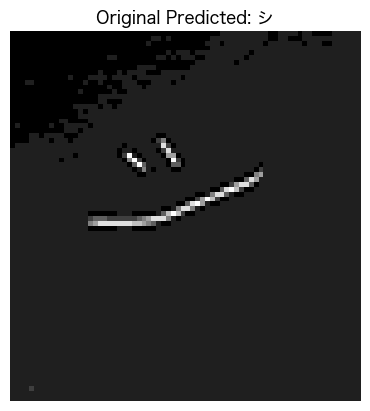

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


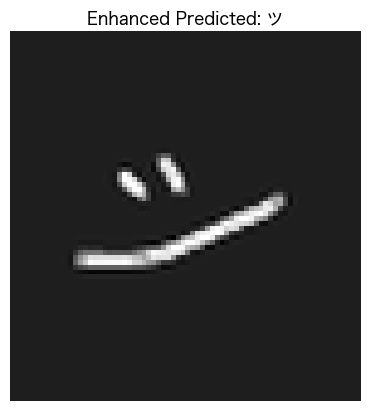

In [12]:


my_imgs_filepath = './my_imgs'
filepaths = ['test1.jpg', 'test2.jpg', 'test3.jpg', 'test4.jpg', 'test5.jpg', 'test6.jpg']
for filename in filepaths:
    full_path = f"{my_imgs_filepath}/{filename}"
    print("Processing:", full_path)
    pred = evaluate_single_image(pipeline.model, full_path, pipeline.class_names, show_graphs=True)

In [9]:
# confirm my mapping works
# display_class_samples(pipeline.mapped, katakana_chars_modern, pipeline.mapping)

In [10]:
# Create json for classnames. Used in prediction standable function
with open('class_names.json', 'w') as f:
    json.dump(pipeline.class_names, f)
print("Class names saved to class_names.json")

Class names saved to class_names.json


Inversion detected: inverting image.
Low contrast detected (std = 0.045): enhancing contrast.
DEBUG: Original image - mean: 0.210, std: 0.076
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


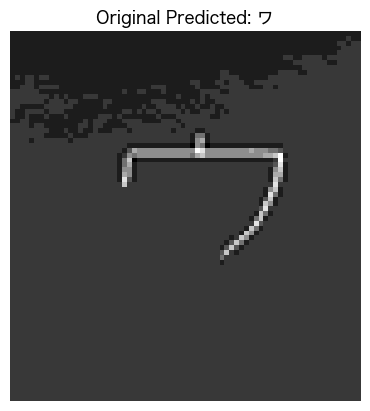

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


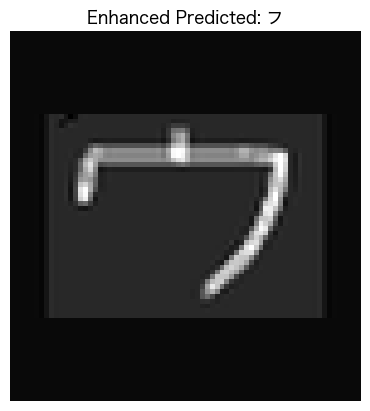

フ


In [13]:


pred = evaluate_single_image(pipeline.model, './my_imgs/test3.jpg', pipeline.class_names, show_graphs=True)
print(pred)